## Similiarity Rating Interpolation Project

_Written by Ariel Zeleznikow-Johnston  
ariel.zeleznikow-johnston@monash.edu  
Last updated 11-Nov-2020_

This project is an attempt to simulate similarity rating interpolations from incomplete data. The aim of this part of the project is to see if a colour hue circle in phenomenological space can be ascertained from incomplete comparisons of samples within that space, given different similarity rating generation metrics

In [65]:
# libraries
library(MASS) # for MDS
library(ggplot2) # for plotting
library(RColorBrewer) # for colour scales in plots
library(gridExtra) # for merging plots
library(grid) # for merging plots
library(ggplotify) # for merging plots
library(reshape2)# for messing with data
library(forcats)
#library(colorRamps)
library(stringr)
library(tidyr)

Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"
Attaching package: 'tidyr'

The following object is masked from 'package:reshape2':

    smiths



In [14]:
# Define some constants
n.dim = 2
radius = 1
dr.max = 1
dr.min = 0
exp.const = 2
n.qualia=5
n.subject.groups = 3

### The phenomenological space

First, we need to define the space from which we're going to try and obtain similarity ratings. For current purposes, we're going to define an isoluminant maximally-saturated hue circle as a unit circle in a metric space of R<sup>2</sup>

In [15]:
# Polar to cartesian 
pol2cart <- function(radius,angle){
    x <- radius*cos(angle)
    y <- radius*sin(angle)
    return(c(x,y))
}

In [16]:
# Get samples from the hue circle
sample.hue.circle <- function(n.samples, distribution='uniform',offset=0, format='cartesian'){
    output <- matrix(, nrow = n.samples, ncol = n.dim) # initialise the output matrix
    
    # obtain the samples
    interval.angle <- 2*pi/n.samples
    for(i in (1:n.samples)){
        theta <- i*interval.angle + offset*interval.angle
        if(format == 'cartesian'){
            output[i,1:2] <- pol2cart(radius,theta)
        } else if (format == 'polar'){
            output[i,1:2] <- c(radius,theta)
        }
    }
    return(output)
}

In [17]:
# colour the plot appropriately
# revise to work with multiple subject groups
colors <- function(n.qualia,n.groups){
    
    color.choices <- brewer.pal(n.groups,"Set1")
    color.v <- c()
    
    for(group in 1:n.groups){
        color <- color.choices[group]
        colors <- rep(color,n.qualia/n.groups)
        color.v <- c(color.v, colors)
    }   
    
    return(color.v)
}

In [18]:
# label the plot points appropriately
# revise to work with multiple subject groups

labels <- function(n.qualia,n.groups){
    
    labels <- c()
    k = 1
    
    for(group in 1:n.groups){
        for(quale in 1:(n.qualia/n.groups)){
            k = quale*n.groups + group  -n.groups # label the actual consecutive stimuli
            if(k < 10){
                k = paste('0',k,sep='')
            }
            label <- paste(k,': ','G',group,'_','Q',quale,sep='')
            labels <- c(labels,label)
            k = 1
        }
    }
    return(labels)
}

In [19]:
# plot sampled hue circles
# revise to work with multiple subject groups

sample.plot <- function(group.list,n.qualia,n.groups,half=FALSE,rainbow=FALSE){
    
    
    
    points <- do.call(rbind,group.list)
    colnames(points) <- c('V1','V2')
    points <- data.frame(points)
    
    # get the colors & labels
    if(half){
        points <- sample.hue.circle(24)
        colnames(points) <- c('V1','V2')
        points <- data.frame(points)
        
        color.choices <- brewer.pal(2,"Set1")
        color1 <- rep(color.choices[1],n.qualia/2)
        color2 <- rep(color.choices[2],n.qualia/2)
        colors <- c(color1,color2)
        labels <- c()
        k = 1
        for(col1 in 1:(n.qualia/2)){
            label <- paste(k,': ','G',1,'_','Q',col1,sep='')
            labels <- c(labels,label)
            k = k + 1
        }
        for(col2 in 1:(n.qualia/2)){
            label <- paste(k,': ','G',2,'_','Q',col2,sep='')
            labels <- c(labels,label)
            k = k + 1
        }
        points$labels <- labels
        
    } else if(rainbow) {
        colors <- rainbow(n.qualia)
        points$labels <- labels(n.qualia,n.groups)
    } else {
        colors <- colors(n.qualia,n.groups)
        points$labels <- labels(n.qualia,n.groups)
    }
    
    
    plot <-     ggplot(points, aes(x = V1, y = V2, color=colors)) + geom_point(size =10) + 
                geom_text(aes(label=labels, vjust=-2)) +
                xlab("Green - Red") + ylab("Blue - Yellow") + 
                ggtitle('Phenomenological Space') + theme(legend.position='none') +scale_colour_identity()
    return(plot)
}

In [20]:
# divide the hue circle up into the judgments each group is going to make
sample.groups <- function(n.qualia,n.groups){
    
    group.judgments <- list()
    k = 1
    
    for(group in 1:n.groups){
        samples <- sample.hue.circle(n.samples=n.qualia/n.groups, offset = group/n.groups)
        group.judgments[[k]] <- samples
        k = k + 1
    }
    
    return(group.judgments)
}

Warning message in brewer.pal(2, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

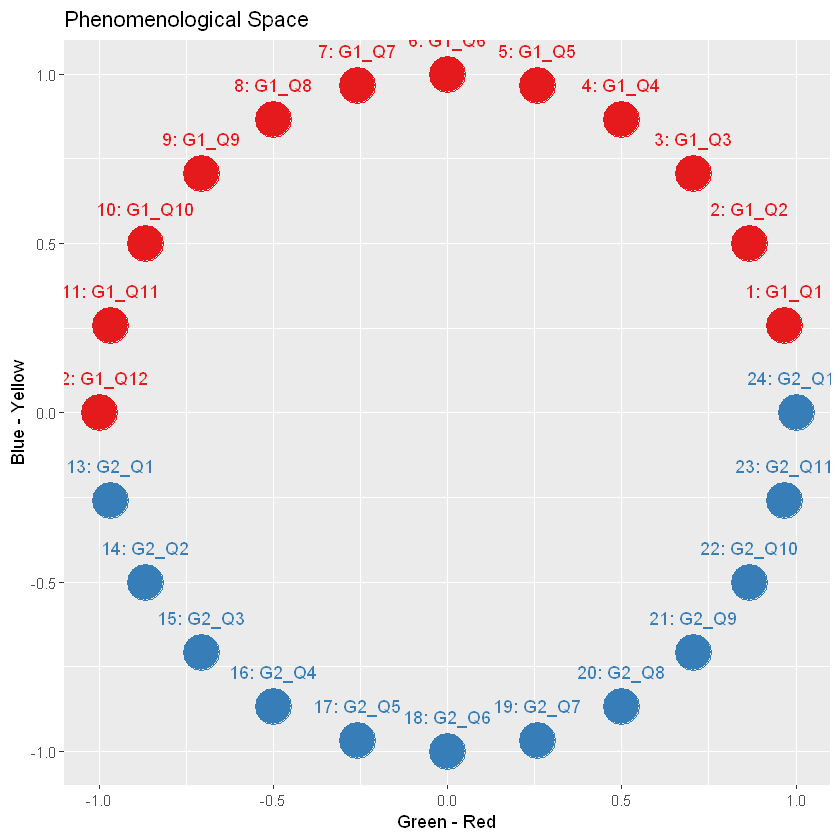

In [21]:
sample.plot(sample.groups(24,1),24,1,half=TRUE)

Let's obtain some samples

Warning message in brewer.pal(n.groups, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

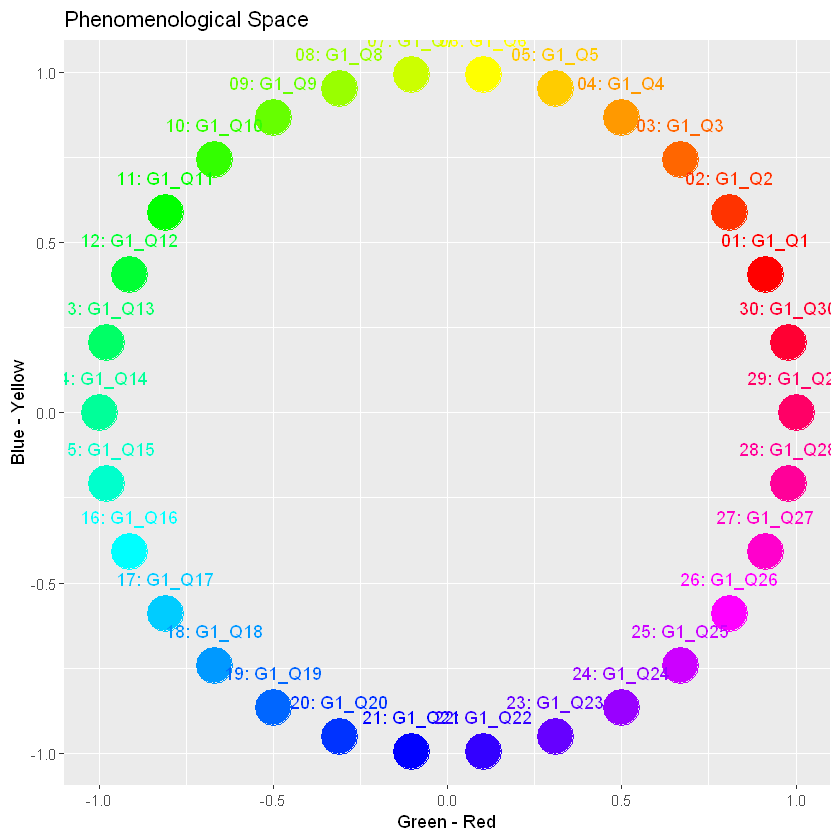

[1] -0.5000000  0.8660254

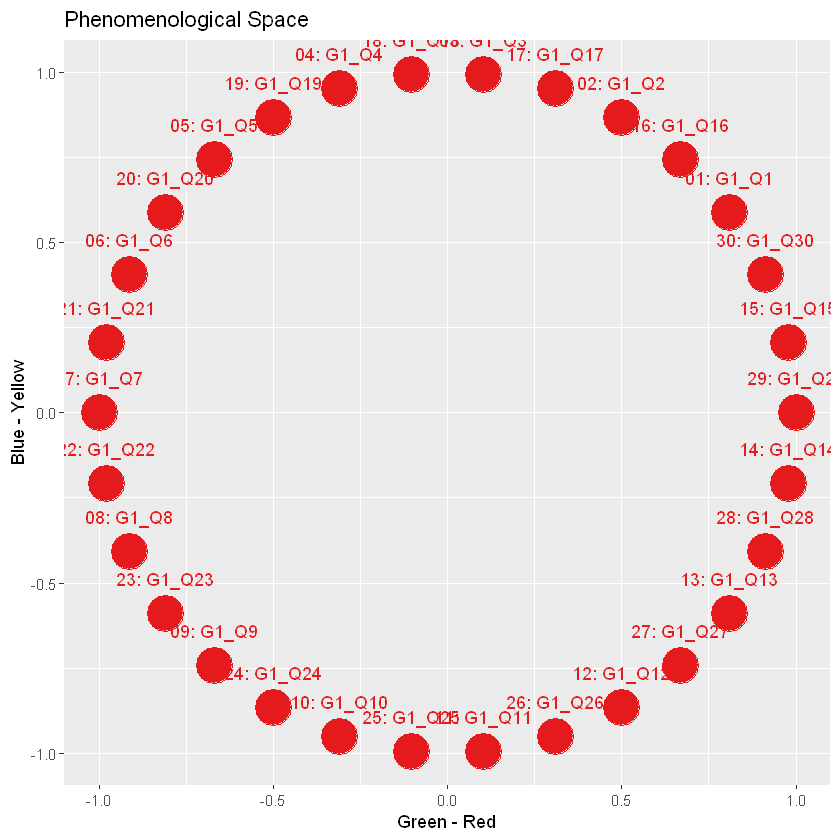

In [22]:
a <- 30
b <- 2
p.data <- sample.groups(a,b)
#p.data
qspace.plot <- sample.plot(p.data,a,1)
sample.plot(sample.groups(30,1),a,1,rainbow=TRUE)
qspace.plot
p.data[[2]][4,1:2]


### Generating similarity ratings

Next, we need to calculate the similarity ratings based on the samples obtained and some metric that can provide dissimilarities based on two points in the phenomenological space. We can use various different distance functions to do this. We can also add noise to the similarity ratings at this time if we wish, to simulate noisy data from subjects under real-world conditions

In [23]:
# Different distance functions
d.euclidean <- function(a,b){
    a <- as.numeric(a)
    b <- as.numeric(b)
    d <- sqrt( (a[1]-b[1])**2 + (a[2]-b[2])**2 )
    return(d)
}

d.shepard <- function(a,b){
    d.eu <- d.euclidean(a,b)
    d.shepard <- exp.const**d.eu-1
    return(d.shepard)
}

In [24]:
# Add some noise to the similarity ratings
noise <-function(var,dr.max,type='gaussian'){
    if(type=='gaussian'){
        error <- rnorm(1,mean=0,sd=var) * dr.max
    }
    return(error)
}

In [25]:
# generate DR matrices across subjects with overlapping similarity judgments
dr.overlap <- function(group.list,metric='d.shepard',var=0,diagnose=FALSE,index=FALSE, overlap=0, reverse=FALSE){
    
     # populate the matrix
    n.samples <- nrow(group.list[[1]])
    n.groups <- length(group.list)
    n.qualia <- n.samples*n.groups
    if(diagnose){
        print(paste('n.samples',n.samples))
        print(paste('n.groups',n.groups))
        print(paste('n.qualia',n.qualia))
    }
    
    points <- do.call(rbind,group.list)
    
    method <- match.fun(metric) # select the metric of choice
    mat <- matrix(,nrow=n.qualia,ncol=n.qualia)  # initialise a matrix
    names <- labels(n.qualia,n.groups)
    colnames(mat) <- c(names)
    rownames(mat) <- c(names)
    dr.max <- method(c(-1,-1),c(1,1)) # Find the maximum possible dissimilarity rating
    
    # get the values
    for(group in 1:n.groups){
        for(q1 in 1:(n.samples + overlap)){
            for(q2 in 1:(n.samples + overlap)){
                
                q1.i <- ( ( (group-1)*n.samples+q1 - 1) %% (n.qualia) + 1)
                q2.j <- ( ( (group-1)*n.samples+q2 - 1) %% (n.qualia) + 1)
                
                
                                
                q1.p <- points[q1.i,1:2]
                q2.p <- points[q2.j,1:2]
                val <- (method(q1.p,q2.p) + noise(var,dr.max))/dr.max # not sure this is calculated correctly, where I should be applying the noise...
                if(val > 0){ # no negative dissimilarity values. Needed to avoid noise making this negative
                    mat[q1.i,q2.j] <- val
                } else {
                    mat[q1.i,q2.j] <- 0
                }
                if(diagnose){
                    print(points)
                    print(paste('group',group))
                    print(paste('q1',q1))
                    print(paste('q2',q2))
                    print(paste('q1.i',q1.i))
                    print(q1.p)
                    print(paste('q2.j',q2.j))
                    print(q2.p)
                    print(val)
                    print("")
                }
                if(index){
                    mat[q1.i,q2.j] <- paste('q1.i:',q1.i,' ','q2.j:',q2.j,'        ')
                                            #round(q1.p[1],2),round(q1.p[2],2),'_',round(q2.p[1],2),round(q2.p[2],2))
                }
            }
        }
    }
    
    #return the matrix
    return(mat)
}

In [26]:
# divide up the space, compare every quale to every other quale not including itself
dr.every.other <- function(n.qualia, metric='d.shepard',var=0,diagnose=FALSE){
    
    method <- match.fun(metric) # select the metric of choice
    mat <- matrix(,nrow=n.qualia,ncol=n.qualia)  # initialise a matrix
    n.samples <- n.qualia/2
    dr.max <- method(c(-1,-1),c(1,1)) # Find the maximum possible dissimilarity rating
    
    
    names <- labels(n.qualia,2)
    colnames(mat) <- c(names)
    rownames(mat) <- c(names)
    if(diagnose){
        print(names)
    }
    
    # get the values
    Q1 <- sample.hue.circle(n.samples=n.qualia/2)
    Q2 <- sample.hue.circle(n.samples=n.qualia/2, offset=0.5)
    
    # populate the Q1 x Q2 matrix
    for(i in (1:n.samples)){
        q1 <- Q1[i,1:2]
        for(j in (1:n.samples)){
            q2 <- Q2[j,1:2]
            
            val <- (method(q1,q2) + noise(var,dr.max=dr.max))/dr.max # not sure this is calculated correctly, where I should be applying the noise...
            
            if(diagnose){
                print(paste('q1: x',round(q1[1],2),'y:',round(q1[2],2)))
                print(paste('q2: x',round(q2[1],2),'y:',round(q2[2],2)))
                print(val)
                print("")
            }
            
            if(val > 0){ # no negative dissimilarity values. Needed to avoid noise making this negative
                mat[i,j+n.samples] <- val
            } else {
                mat[i,j+n.samples] <- 0
            }
            mat[i,j+n.samples] 
        }
    }
    # transpose the results to make the bottom right comparisons
    mat[(n.samples+1):(n.samples*2), 1:n.samples] <- t(mat[1:n.samples,(n.samples+1):(n.samples*2)])
    
    
    return(mat)
    
}

In [27]:
# divide up the space, compare every quale to every other quale not including itself
dr.half <- function(n.qualia, metric='d.shepard',var=0,diagnose=FALSE){
    
    method <- match.fun(metric) # select the metric of choice
    mat <- matrix(,nrow=n.qualia,ncol=n.qualia)  # initialise a matrix
    n.samples <- n.qualia/2
    dr.max <- method(c(-1,-1),c(1,1)) # Find the maximum possible dissimilarity rating
    
    names <- labels(n.qualia,1)
    colnames(mat) <- c(names)
    rownames(mat) <- c(names)
    
    # get the values
    Q <- sample.hue.circle(n.qualia)
    Q1 <- Q[1:n.samples,1:2]
    Q2 <- Q[(n.samples+1):n.qualia,1:2]
    
    # populate the Q1 x Q2 matrix
    for(i in (1:n.samples)){
        q1 <- Q1[i,1:2]
        for(j in (1:n.samples)){
            q2 <- Q2[j,1:2]
            val <- (method(q1,q2) + noise(var,dr.max=dr.max))/dr.max # not sure this is calculated correctly, where I should be applying the noise...
            if(val > 0){ # no negative dissimilarity values. Needed to avoid noise making this negative
                mat[i,j+n.samples] <- val
            } else {
                mat[i,j+n.samples] <- 0
            }
            mat[i,j+n.samples] 
        }
    }
    # transpose the results to make the bottom right comparisons
    mat[(n.samples+1):(n.qualia), 1:n.samples] <- t(mat[1:n.samples,(n.samples+1):(n.qualia)])
    
    return(mat)
    
}

In [28]:
# compare all qualia to particular reference qualia
dr.cols <- function(n.qualia,v.cols,metric='d.shepard',var=0,diagnose=FALSE){
    method <- match.fun(metric) # select the metric of choice
    mat <- matrix(,nrow=n.qualia,ncol=n.qualia)  # initialise a matrix
    n.samples <- n.qualia/2
    dr.max <- method(c(-1,-1),c(1,1)) # Find the maximum possible dissimilarity rating
    
    points <- sample.hue.circle(n.samples=n.qualia)
    
    names <- labels(n.qualia,1)
    colnames(mat) <- c(names)
    rownames(mat) <- c(names)
    
    if(diagnose){
        print(paste('n.qualia',n.qualia))
        print(paste('v.cols',v.cols))
        print(paste('length v.cols',length(v.cols)))
    }
    
    # get the values
    for(col in 1:length(v.cols)){
        for(row in 1:n.qualia){
            q1 <- points[v.cols[col],1:2]
            q2 <- points[row,1:2]
            
            val <- (method(q1,q2) + noise(var,dr.max))/dr.max # not sure this is calculated correctly, where I should be applying the noise...
            if(val > 0){ # no negative dissimilarity values. Needed to avoid noise making this negative
                mat[row,v.cols[col]] <- val
            } else {
                mat[row,v.cols[col]] <- 0
            }
        }
    }
    return(mat)
}

In [31]:
#v <- c(1,2,4)
#dr.mat.cols <- dr.groups.column(12,v)

In [32]:
 #dr.groups(sample.groups(6,3),overlap=1,metric='d.shepard',diagnose=TRUE)

Let's obtain the similarity ratings from the samples, comparing each quale in Q1 to each quale in Q2 (but not _Q1 to Q1_ or _Q2 to Q2_ )

In [34]:
#dr.matrix <- dr.groups(sample.groups(6,3),diagnose=FALSE,overlap=3,metric='d.shepard',var=0.00)

In [36]:
#dr.matrix.half <- dr.groups.halving(12,metric='d.shepard',var=0.00)
#dr.matrix.half

In [37]:
# generic matrix plot stuff
plot.mat <- function(mat, reverse=TRUE, refactor=TRUE,
                                  col1='blue',col2='orange',na.col='green',
                                  legend.title='value',overall.title='',
                                  xlabel='',
                                  ylabel='',
                                  low.lim=0,up.lim=dr.max*1.5){
    
    
    
    
    
    if(reverse){
        mat <- mat[nrow(mat):1,]
    }
    
    longData <- melt(mat)
    
    # sometimes has issues without this
    if(refactor){
        longData$Var1 <- factor(longData$Var1)
        longData$Var2 <- factor(longData$Var2)
        #print((longData$Var1))
        longData$Var1 <- fct_relevel(longData$Var1, sort)
        longData$Var2 <- fct_relevel(longData$Var2, sort)
        longData$Var1 <- fct_relevel(longData$Var1, rev)
    }
    
    # plot
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    #scale_y_discrete(limits = rev(mat$Var1)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,0,up.lim),
                        na.value=na.col) +
    ggtitle(overall.title) + xlab(xlabel) + ylab(ylabel) + theme(axis.text.x = element_text(angle=90, vjust =0.5,hjust=1))

    return(plot)
}

In [39]:
#plot.mat(dr.matrix.half,low.lim=0,up.lim=1.5)
#plot.mat(dr.mat.cols,low.lim=0,up.lim=1.5)

### Interpolate the missing data

So far the full dissimilarity matrix is incomplete, as we have only got Q1 to Q2 comparisons, but no (Q1 to Q1) nor (Q2 to Q2). To interpolate these, we're going to try a method Nao suggested based on the correlations between the experiences.  
  
Specifically, we're going to assume that the dissimilarity between Q1<sub>i</sub> and Q1<sub>j</sub> is defined as the correlation of the vector comprising all the comparisons between Q1<sub>i</sub> and Q2 to the vector comprising all the comparisons between Q1<sub>j</sub> and Q2.   

If the data is incomplete, we'll just use the data that we can use and hope for the best.

In [40]:
# Formula for converting correlation to dissimilarity value
cor2dr <- function(correlation,scale){
    return(-(correlation-1)/2*scale)
}

In [41]:
# Formula for converting vector distance to dissimilarity value
vec2dist <- function(v1,v2,scale){
    dist <- sqrt(sum(v1 - v2)^2)
    return(dist*scale)
}

In [42]:
# Obtain which indices are not NA for both of two vectors
check.na <- function(v1,v2){
    input <- data.frame(v1,v2)
    input$output <- (!(is.na(v1)) & !(is.na(v2)))
    return(input$output)
}

In [43]:
# Interpolate a dissimilarity value based on the correlation between two vectors
interpolate <- function(v1,v2,r='spearman',type='correlation',diagnose=FALSE){

    input <- data.frame(v1,v2,check.na(v1,v2))
    clean <- subset(input, check.na.v1..v2. == TRUE)
    
    
    # choose a max DR to scale by
    max.dr <- max(c(max(clean$v1),max(clean$v2)))
    
    if(type=='correlation'){
        r.val <- cor(clean$v1,clean$v2,method=r)
        val <- cor2dr(r.val,scale=max.dr)
    } else if (type == 'vector'){
        val <- vec2dist(clean$v1,clean$v2,scale=max.dr)
    }
    
    if(diagnose){
        print(clean) # testing
        r.print <- cor2dr(cor(clean$v1,clean$v2,method=r),scale=max.dr)
        print(paste('Correlation:',r.print))
        v.print <- vec2dist(clean$v1,clean$v2,scale=max.dr)
        print(paste('Vector distance:',v.print))
    }
    
    return(val)
}

In [44]:
# Produce a new matrix with interpolated data. Choose the correlation function of choice
interpolate.matrix <- function(matrix,r='spearman',mode='mat',type='correlation',diagnose=FALSE){
    output <- matrix(,nrow(matrix),ncol(matrix))
    
    for(i in (1:nrow(matrix))){
        for(j in (1:ncol(matrix))){
            if(is.na(matrix[i,j])){
                if(mode=='mat'){
                    v1 <- na.omit(as.vector(matrix[i,1:nrow(matrix)]))
                    v2 <- na.omit(as.vector(matrix[j,1:nrow(matrix)]))
                } else {
                    v1 <- as.vector(matrix[i,1:nrow(matrix)])
                    v2 <- as.vector(matrix[j,1:nrow(matrix)])
                }
                
                
                vals <- na.omit(c(v1,v2))
                #max.dr <- max(vals) # grab the maximum dissimilarity value for a scaling constant
                
                output[i,j] <- interpolate(v1,v2,type=type,diagnose=diagnose)
            } else {
                output[i,j] <- matrix[i,j]
            }
        }
    }
    colnames(output) <- colnames(matrix)
    rownames(output) <- rownames(matrix)
    return(output)
}

In [46]:
#dr.interpolated.v <- interpolate.matrix(dr.matrix,type='vector')
#dr.interpolated.r <- interpolate.matrix(dr.matrix,mode='other',type='correlation')
#dr.interpolated.r <- interpolate.matrix(dr.mat.cols,mode='other',type='correlation')

In [48]:
#plot.mat(dr.interpolated.r)
#plot.mat(dr.interpolated.v)

### Try and reconstruct the phenomenological space

Now that we have a full dissimilarity matrix comprised of original and interpolated data, we will try and see if we can reconstruct the phenomenological space from this matrix.

In [49]:
# plot an MDS fit
cmdsplot <- function(dr.int,n.groups,k=2,var=0){
    
    #print(n.qualia) # testing
    n.qualia <- nrow(dr.int)
    #print(dr.matrix)
    #dr.int <- interpolate.matrix(dr.matrix,method='pearson')
    #print(dr.int) # testing
    fit <- cmdscale(dr.int,k) # do the MDS   
    fit <- as.data.frame(fit)
    
    colors <- colors(n.qualia,n.groups)
    labels <- labels(n.qualia,n.groups)
    
    plot <-     ggplot(fit, aes(x = V1, y = V2, color=colors)) + geom_point(size =10) + 
                geom_text(aes(label=labels, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle((paste('Classical MDS - ','SD = ',var,'*','(MAX DR)',sep=''))) + 
                theme(legend.position='none') +scale_colour_identity()
    
    return(plot)
}

Let's see what it looks like on the full dissimilarity matrix

In [53]:
#interpolate.plot <- cmdsplot(dr.interpolated.r,n.groups=1,var=0.00)
#interpolate.plot

Let's compare this to the original phenomenological space

In [54]:
# compare the phenomenological space to the cmds
compare.plots <- function(qspace.plot,interpolate.plot){
    grob <- arrangeGrob(qspace.plot,interpolate.plot,
                       nrow = 1, ncol = 2)
}

In [56]:
#compare <- compare.plots(qspace.plot, interpolate.plot)
#grid.arrange(compare)

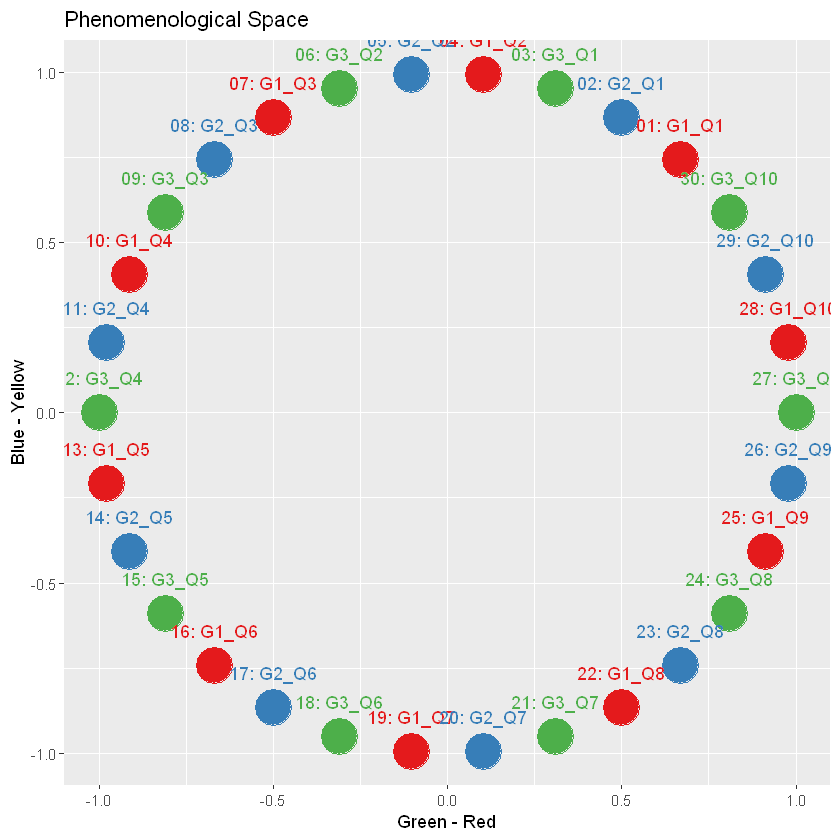

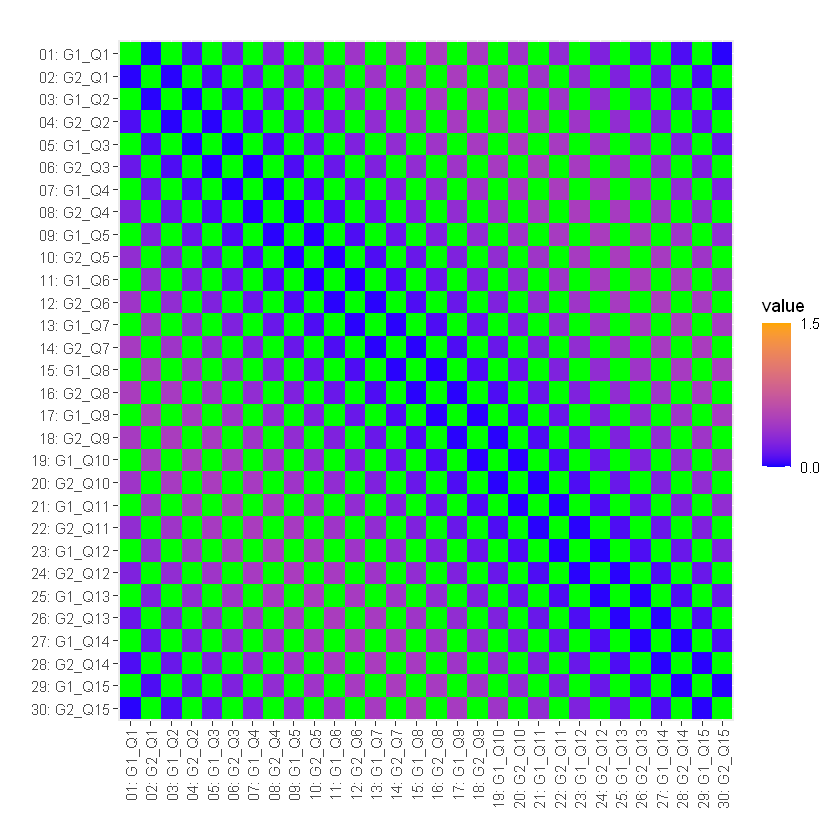

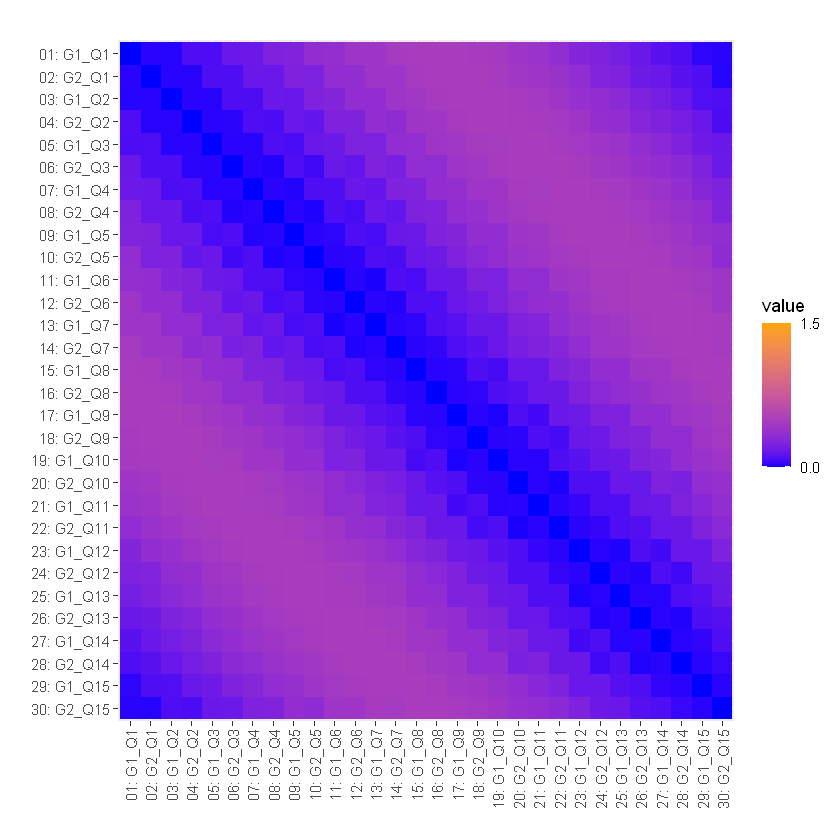

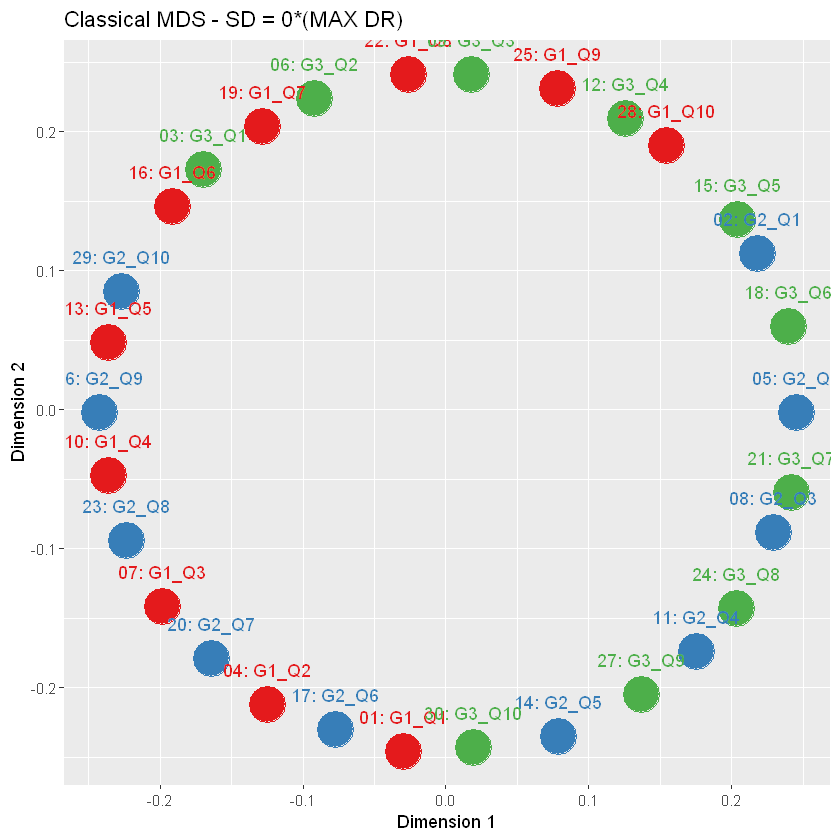

In [57]:
# just doing everyting all at once for presentation purposes
qualia <- 30
groups <- 3
overlap <- 0
qspace.plot <- sample.plot(sample.groups(qualia,groups),qualia,groups)
qspace.plot

# specify the matrix type
#dr.matrix <- dr.overlap(sample.groups(qualia,groups),diagnose=FALSE,overlap=overlap,metric='d.shepard',var=0.00)
#dr.matrix <- dr.half(24)
#dr.every.other(6)
dr.matrix <- dr.every.other(30,diagnose=FALSE)
v <- c(1,5,9,13,17,21)
#dr.matrix <- dr.cols(qualia,v)

plot.mat(dr.matrix,low.lim=0,up.lim=1.5, refactor=TRUE, reverse=TRUE)
#plot.mat(dr.matrix,low.lim=0,up.lim=1.5)
dr.interpolated.r <- interpolate.matrix(dr.matrix,mode='other',type='correlation')
plot.mat(dr.interpolated.r, refactor=TRUE)

#interpolate.plot <- cmdsplot(dr.interpolated.r,n.groups=groups,var=0.00)
interpolate.plot <- cmdsplot(dr.interpolated.r,n.groups=3,var=0.00)

interpolate.plot

### Putting everything together in one go

In [35]:
test <- function(n=9,var=0){
    Q1 <- sample.hue.circle(n.samples=n)
    Q2 <- sample.hue.circle(n.samples=n, offset=0.5)
    qspace.plot <- sample.plot(Q1,Q2)
    interpolate.plot <- cmdsplot(Q1,Q2,n.qualia=n,k=2,var=var)
    compare <- compare.plots(qspace.plot, interpolate.plot)
    grid.arrange(compare)
}


In [36]:
#test(8,var=0.5)

In [60]:
# make a demonstration plot
demo.plot <- function(type='correlation',diagnose=FALSE){
    
    stim.list <- c(3,4,8,12)
    noise.list <- c(0.01,0.05,0.1)

    
    k = 1 # counter
    plot_list <- list() # list to store the plots in as we're making them
    
    for(stim in stim.list){
        print(k) # testing
        Q1 <- sample.hue.circle(n.samples=stim)
        Q2 <- sample.hue.circle(n.samples=stim, offset=0.5)
        qspace.plot <- sample.plot(Q1,Q2)
        plot_list[[k]] <- as.grob(qspace.plot)
        k = k + 1   
                      
        for(noise in noise.list){
            dr.matrix <- dr(n.samples=stim,Q2,Q1,metric=d.shepard,var=noise)
            plot_list[[k]] <- as.grob(plot.mat(dr.matrix,overall.title='Original Data'))
            k = k + 1
            
            dr.int <- interpolate.matrix(dr.matrix,type=type,diagnose=diagnose)
            #print(dr.int)
            plot_list[[k]] <- as.grob(plot.mat(dr.int,overall.title='Interpolated'))
            k = k+1
            
            interpolate.plot <- cmdsplot(dr.int,var=noise,Q1=Q1,Q2=Q2)
            plot_list[[k]] <- as.grob(interpolate.plot)
            k = k+1
        }        
    }
    g <- arrangeGrob(grobs = plot_list, ncol = length(noise.list)*3+1, nrow = length(stim.list))
    ggsave(paste('Demo',type,'.png'),g,height=25,width=49)
}

In [61]:
#demo.plot(type='vector',diagnose=FALSE)
#demo.plot(type='correlation')

### Splicing Method Trial


In [62]:
n.qualia = 30

# hue circle
#sample.plot(sample.groups(30,1),a,1,rainbow=TRUE)
circle.points <- sample.groups(n.qualia,1)[[1]]
# plane - uniform

# plane - random

In [66]:
# add some labels

stim.int <- 1:n.qualia
stim.pad <- str_pad(stim.int,2,pad='0')
stim.labs <- paste('S',stim.pad,sep='')

circle.points <- cbind(circle.points,stim.labs)
#circle.points

In [67]:
# obtain the labeled stimuli

seq.points <- function(points, groups, rand=FALSE,mode='seq'){
    if(rand){
        rn <- sample.int(nrow(points))
        points <- cbind(points,rn)
        points <- points[order(rn),]
    }
    out.list <- list()
    increment <- nrow(points)/groups
    k.p = 1
    k.g = 1
    row.ids <- c(1:nrow(points))
    points <- cbind(points,row.ids)
    
    for(group in 1:groups){
        if(mode == 'seq'){
            out <- points[k.p:(k.p+increment-1),1:3]
        } else if (mode == 'eo'){
             out <- points[as.numeric(points[,'row.ids']) %% groups == (group-1),]
        }
        
        k.p = k.p + increment
        out.list[[k.g]] <- out
        k.g = k.g + 1
    }
    
    # label the points
    labels(nrow(points),groups)
    
    return(out.list)
}

eo.points <- function(points,groups){
    out.list <- list()
    increment <- nrow(points)/groups
    k.p = 1
    k.g = 1
    
    
    
    for(group in 1:groups){
       
        k.p = k.p
    }
}

In [68]:
#seq.points(circle.points,3,mode='eo')

In [72]:
# obtain the colour groups
circ.seq <- seq.points(circle.points,3,mode='eo',rand=TRUE)
circ.rand <- seq.points(circle.points,3,rand=TRUE)

In [73]:
# Generate the 'empirical' DR matrices for a subgroup of circle.points

dr.simple <- function(circle.points,G1,G2,metric='d.shepard',var=0,label=FALSE,diagnose=FALSE){
    
    G1.points <- circle.points[[G1]]
    G2.points <- circle.points[[G2]]
    
    method <- match.fun(metric)
    n.samples <- nrow(G1.points)
    
    if(diagnose){
        print(paste('n.samples',n.samples))
    }
    
    mat <- matrix(,nrow=n.samples,ncol=n.samples)
    dr.max <- method(c(-1,-1),c(1,1))
    
    # labeling
    if(label){
        stim.int <- 1:n.samples
        stim.pad <- str_pad(stim.int,2,pad='0')
        G1.labs <- paste('G',G1,'_','L',stim.pad,'_',G1.points[,3],sep='')
        G2.labs <- paste('G',G2,'_','R',stim.pad,'_',G2.points[,3],sep='')
        colnames(mat) <- G2.labs
        rownames(mat) <- G1.labs
    }

    # obtain the matrix
    for(stim1 in 1:n.samples){
        q1 <- G1.points[stim1,1:2]
        for(stim2 in 1:n.samples){
            q2 <- G2.points[stim2,1:2]
            val <- (method(q1,q2) + noise(var,dr.max=dr.max))/dr.max
            if(val > 0){
                mat[stim1, stim2] <- val
            } else {
                mat[stim1, stim2] <- 0
            }
        }
    }
    
    # output
    return(mat)
    
}

In [74]:
AB.seq <- dr.simple(circ.seq,1,2,label=TRUE)
BC.seq <- dr.simple(circ.seq,2,3,label=TRUE)
CA.seq <- dr.simple(circ.seq,3,1,label=TRUE)

AB.rand <- dr.simple(circ.rand,1,2,label=TRUE)
BC.rand <- dr.simple(circ.rand,2,3,label=TRUE)
CA.rand <- dr.simple(circ.rand,3,1,label=TRUE)

In [75]:
# Round 1 interpolation

expand.mat <- function(mat,int=TRUE){
    n.samples <- nrow(mat)
    n.expand <- n.samples*2
    
    out.mat <- matrix(,nrow=n.expand,ncol=n.expand)
    
    out.mat[1:n.samples,(n.samples+1):n.expand] <- mat
    out.mat[(n.samples+1):n.expand,1:n.samples] <- t(mat)
    
    # labels
    lab <- c(rownames(mat),colnames(mat))
    colnames(out.mat) <- lab
    rownames(out.mat) <- lab
    
    # interpolate
    if(int){
            out.mat <- interpolate.matrix(out.mat)
    }
    
    
    return(out.mat)
}

In [76]:
AB.seq.int <- expand.mat(AB.seq)
BC.seq.int <- expand.mat(BC.seq)
CA.seq.int <- expand.mat(CA.seq)

seq.list <- list(AB.seq.int,BC.seq.int,CA.seq.int)

AB.rand.int <- expand.mat(AB.rand)
BC.rand.int <- expand.mat(BC.rand)
CA.rand.int <- expand.mat(CA.rand)

In [79]:
#plot.mat(AB.seq)
#plot.mat(BC.seq)
#plot.mat(CA.seq, refactor=FALSE)
#plot.mat(expand.mat(AB.seq,int=FALSE))
#plot.mat(expand.mat(BC.seq,int=FALSE))
#plot.mat(expand.mat(CA.seq,int=FALSE),refactor=FALSE)
#plot.mat(AB.seq.int)
#plot.mat(BC.seq.int)
#plot.mat(CA.seq.int, refactor=FALSE)
#plot.mat(seq.list.fuse,refactor=TRUE, reverse=TRUE)
#plot.mat(int.seq,refactor=FALSE)

In [80]:
# Stitch the matrices together
substrRight <- function(x, n){
  substr(x, nchar(x)-n+1, nchar(x))
}

fuse <- function(mat.list){
    
    n.qualia = 0
    # make the matrices into a dataframe
    df <- data.frame()
    for(i in 1:length(mat.list)){
        mat <- mat.list[[i]]
        n.qualia = n.qualia + nrow(mat)
        longData <- melt(mat)
        df <- rbind(df,longData)
    }
    
    # make some new columns based on labels
    df$x <- as.character(df$Var1)
    df$y <- as.character(df$Var2)
    df$xlab <- substrRight(df$x,7)
    df$ylab <- substrRight(df$y,7)
    df <- subset(df, select=c('value','xlab','ylab'))
    
    # make the matrix
    out.mat <- acast(df,xlab~ylab, value=value)
    
    # reorder the matrix columns
    names <- data.frame(ylab = colnames(out.mat))
    names$ystim <- as.numeric(substrRight(as.character(names$ylab),2))
    names$y.pos <- substr(names$ylab,1,1)
    
    names <- names[with(names, order(y.pos,ystim)),]
    names.order <- c(names[1])[[1]]
    
    out.mat <- out.mat[,names.order]
    out.mat <- out.mat[names.order,]
    
    # output
    return(out.mat)
}



In [81]:
# Round 2 interpolation
# need to sort out the matrix first
seq.list.fuse <- fuse(seq.list)
int.seq <- interpolate.matrix(seq.list.fuse)
#int.seq

In [82]:
# MDS visualisation

cmds.fuse.plot <- function(mat,k=2){
    
    fit <- cmdscale(mat,k)
    fit <- as.data.frame(fit)
    labels <- rownames(mat)
    
    plot <-     ggplot(fit, aes(x = V1, y = V2)) + geom_point(size =10) + 
                geom_text(aes(label=labels, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                #ggtitle((paste('Classical MDS - ','SD = ',var,'*','(MAX DR)',sep=''))) + 
                theme(legend.position='none') +scale_colour_identity()
    
    return(plot)
}

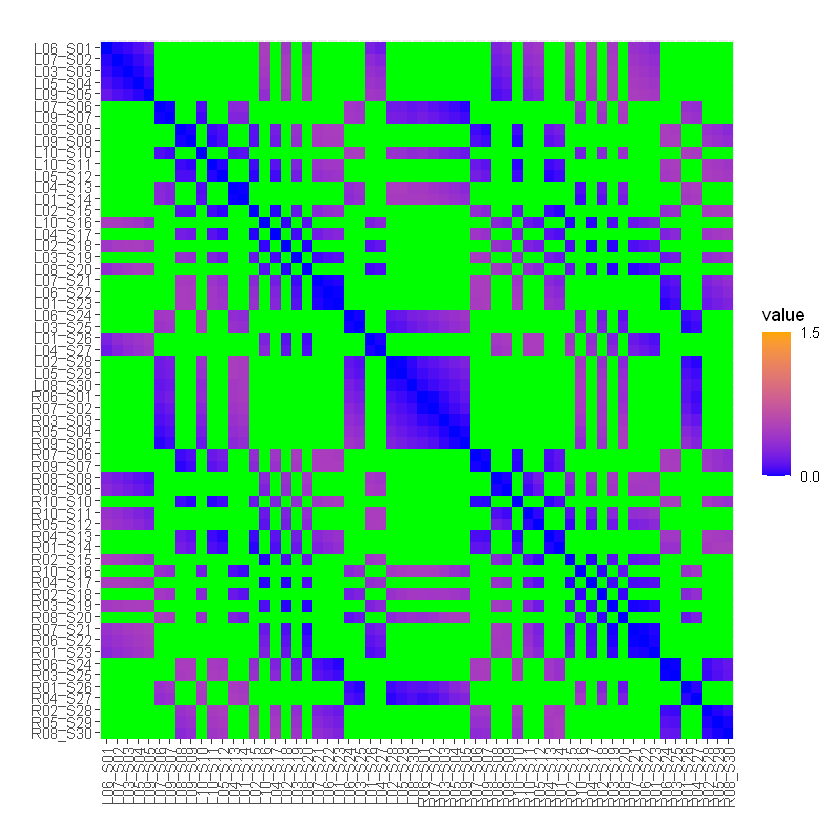

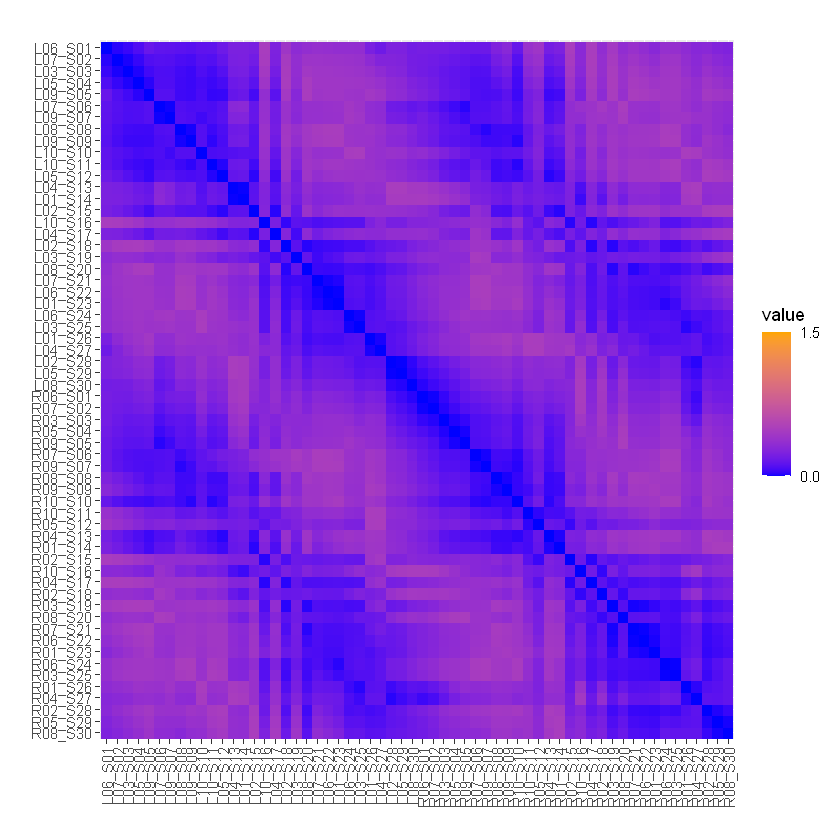

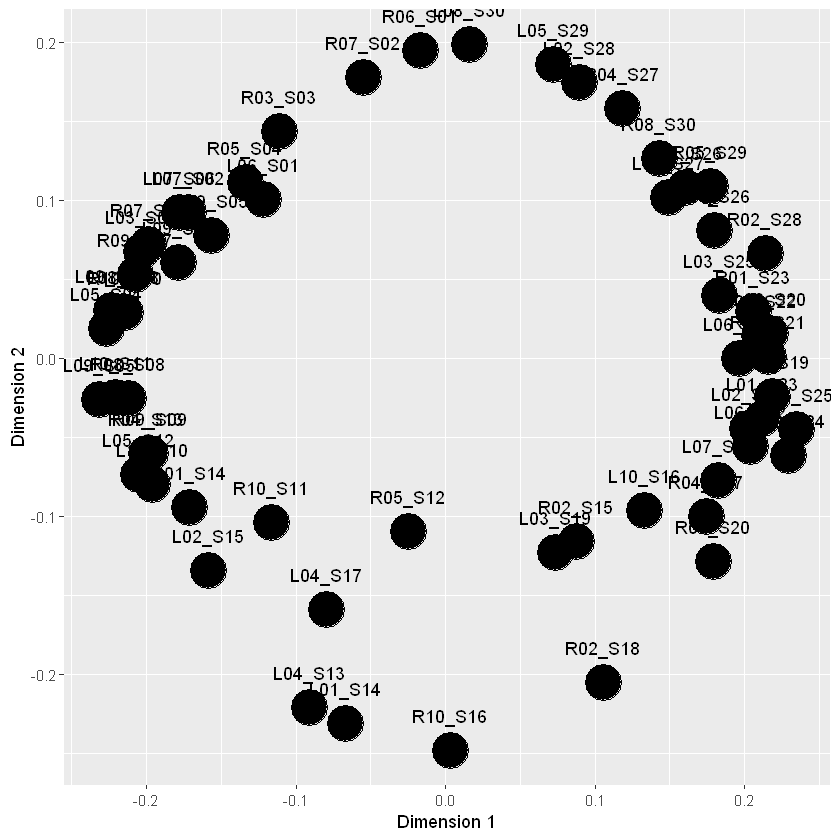

In [83]:
plot.mat(seq.list.fuse,refactor=FALSE)
plot.mat(int.seq,refactor=FALSE)
cmds.fuse.plot(int.seq)

### Interpolation stuff for Nao's DP Grant

In [224]:
weird.mat <- as.matrix(read.table("weird.Rdata"))

In [225]:
#weird.mat <- as.matrix(read.table("scaled.Rdata"))

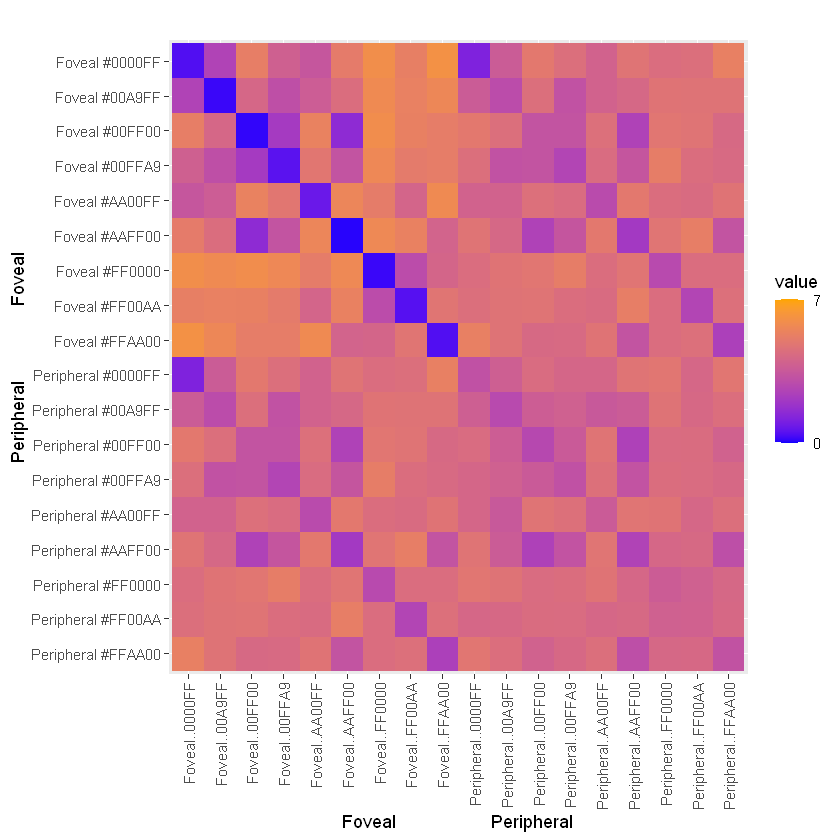

In [226]:
plot.mat(weird.mat,low.lim=0,up.lim=7,
        xlabel = 'Foveal                   Peripheral',
        ylabel = 'Peripheral               Foveal')

In [227]:
# make an expanded matrix from a smaller one
expand.mat <- function(mat){
    out.mat <- matrix(,nrow(mat)*2,ncol(mat)*2)
    n.row <- nrow(mat)
    n.col <- ncol(mat)
    n.col.1 <- n.col+1
    n.col_2 <- n.col*2

    out.mat[ 1 : nrow(mat) , n.col.1 : n.col_2 ] <- mat
    out.mat[ (nrow(mat)+1):(nrow(mat)*2) , 1:ncol(mat) ] <- mat
    return(out.mat)
}

In [228]:
duplicate.mat <- expand.mat(weird.mat)

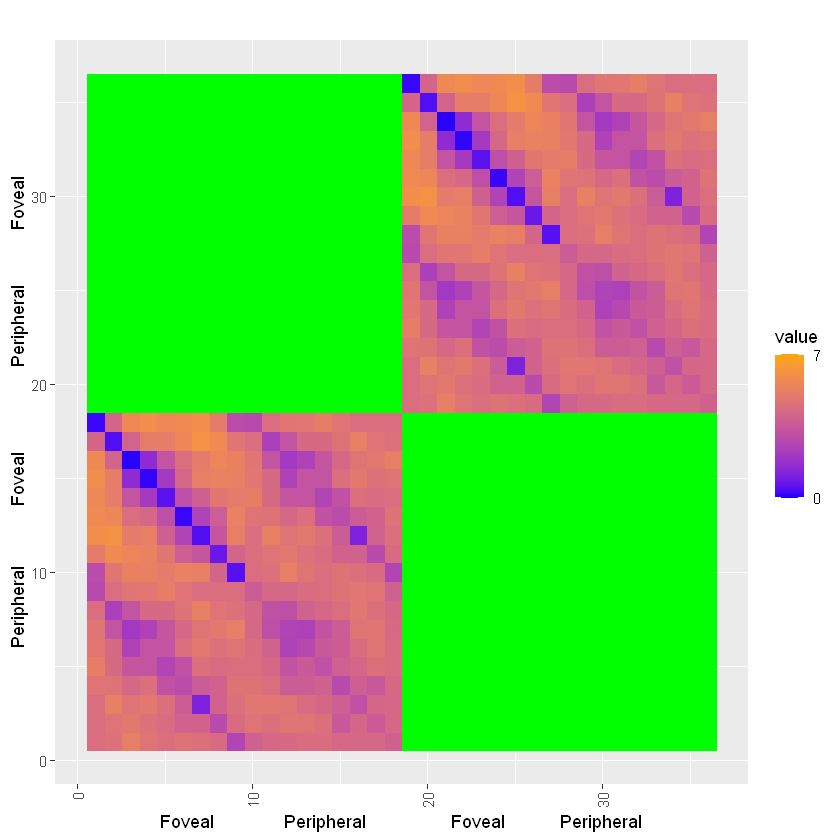

In [229]:
plot.mat(duplicate.mat,low.lim=0,up.lim=7,refactor=FALSE,
        xlabel = 'Foveal              Peripheral                 Foveal           Peripheral',
        ylabel = 'Peripheral            Foveal                 Peripheral           Foveal')

In [230]:

weird.int <- interpolate.matrix(duplicate.mat,mode='mat')

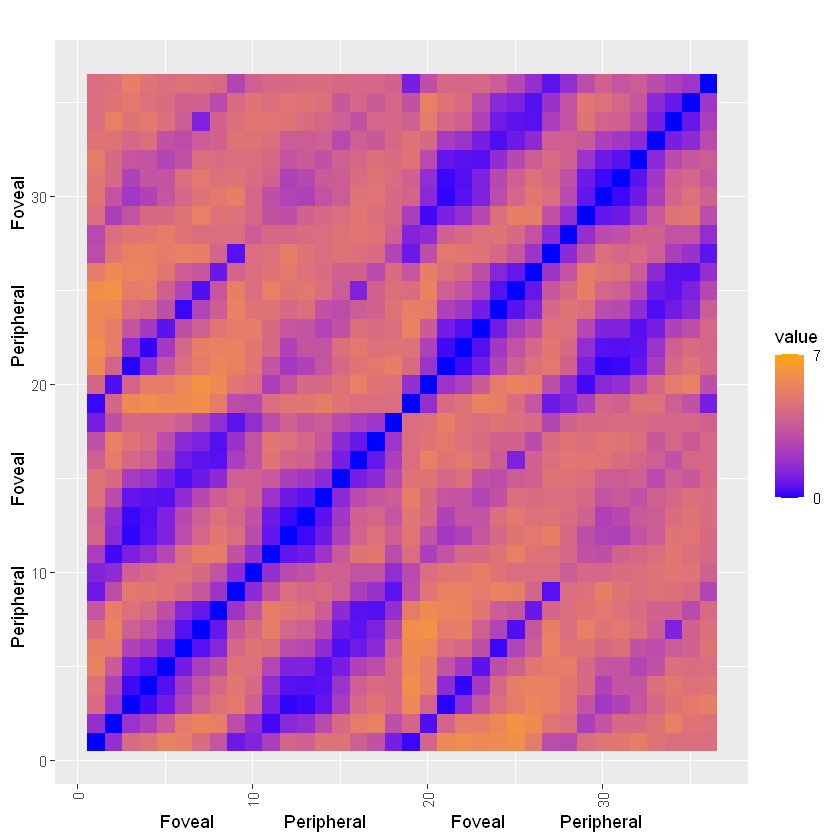

In [231]:

plot.mat(weird.int,low.lim=0,up.lim=7, reverse=FALSE, refactor=FALSE,
        xlabel = 'Foveal              Peripheral                 Foveal           Peripheral',
        ylabel = 'Peripheral            Foveal                 Peripheral           Foveal')

In [232]:
fit <- cmdscale(weird.int,2)
fit <- as.data.frame(fit)


In [233]:
colors <- c(rep('#FFFFB3',9),rep('"#BEBADA',9),rep('#FFFFB3',9),rep('"#BEBADA',9))
black <- c(rep('#000000',36))
rainbow <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
colors2 <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA",'#990000','#99AA00','#669900','#009900','#009965',"#006599",'#000099','#660099',"#990066")
colors3 <- c(colors2,colors2)
colors4 <- c(rainbow,rep('000000',9))
colors6 <- c(rep("000000",9),rainbow)
colors7 <- c(colors6,colors6)
#colors
colors5 <- c(colors4,colors4)
#colors5
colors8 <- c(rainbow,rainbow,rainbow,rainbow)
tags <- c(rep('Central',9),rep('Peripheral',9),rep('Central',9),rep('Peripheral',9))
tags2 <- colors8

In [234]:
#fit2 <- fit[with(fit, order(V1)),]

In [235]:
class(colors7)

[1] "character"

In [236]:
fit$Eccentricity <- c(rep('Central',9),rep('Peripheral',9),rep('Central',9),rep('Peripheral',9))

In [237]:
plot <-     ggplot(fit, aes(x = V1, y = V2, color=colors8)) + geom_point(size =10,aes(shape=Eccentricity)) + 
                #geom_text(aes(label=tags, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle('Classical MDS') + 
                #theme(legend.position='none') +
                scale_colour_identity()

ggsave('presentation.png',plot,height=7,width=10)

### Testing Rank Structure Stuff

Shouldn't be copy-pasting code, fix this please

In [219]:
# test for rank order violation given two values
rank.obtain <- function(vals,invert=FALSE){
    if(vals[1] < vals[2]){ # d(x,y) < d(y,z)
        rank = -1
    } else if (vals[1] == vals[2]){ # d(x,y) = d(y,z)
        rank = 0
    } else if (vals[1] > vals[2]){ # d(x,y) > d(y,z)
        rank = 1
    }
    if(invert){
        return(-rank)
    }
    return(rank)
}

In [220]:
# obtain a set of rank-order matrices within-subject
rank.mat.obtain <- function(mat){
    n.stim <- nrow(mat)
    mat.list <- list()
    for(i in 1:(n.stim)){ # y = i
        rank.mat <- matrix(,nrow(mat),ncol(mat))
        for(j in 1:(n.stim)){ # x = j
            for(k in 1:(n.stim)){ # z = k                
                d.xy <- mat[j,i]
                d.yz <- mat[i,k]
                vals <- c(d.xy, d.yz)
                if( (j==i) | (k==i) ){
                    rank <- NA
                } else {
                    rank <- rank.obtain(vals)
                }
                rank.mat[j,k] <- rank # y = i, place value in a x * z matrix
            }
        }
        mat.list[[i]] <- rank.mat # y = i, full x * z matrix
    }
    return(mat.list)
}

In [221]:
# generic matrix plot stuff
plot.rank.mat.generic <- function(mat){
    
    longData <- melt(mat)
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(colours = c('blue','yellow'),
                         limits = c(-1,1), 
                         breaks=c(-1,0,1),
                        na.value='green')

    return(plot)
}

In [222]:
# plot a set of rank-order matrices
rank.mat.plot.set <- function(mat.list){
    k = 1 # counter
    plot_list <- list()
    
    for(mat in mat.list){
        graph <- plot.rank.mat.generic(mat)
        plot_list[[k]] <- as.grob(graph)
        k = k + 1
    }
    g <- arrangeGrob(grobs = plot_list, ncol = 9, nrow = 2)
    ggsave('rank_mat_plots_demo.png',g,height=8,width=39)
}

In [256]:
# take a set of rank matrices, flatten into one giant matrix
flatten <- function(mat.list){
    n.mats <- length(mat.list)
    x <- sqrt(n.mats)
    n.elements <- n.mats*n.mats
    flat.mat <- matrix(,n.mats*ceiling(x),n.mats*floor(x))  
   
    count = 1
    
    for(i in 1:ceiling(x)){
        for(j in 1:floor(x)){

            if(count <= length(mat.list)){
                flat.mat[((i*n.mats)-(n.mats-1)):((i*n.mats)) , ((j*n.mats)-(n.mats-1)):((j*n.mats))] <- mat.list[[count]]
                count = count + 1
            }
            
        }
    }
    
    return(flat.mat)
}

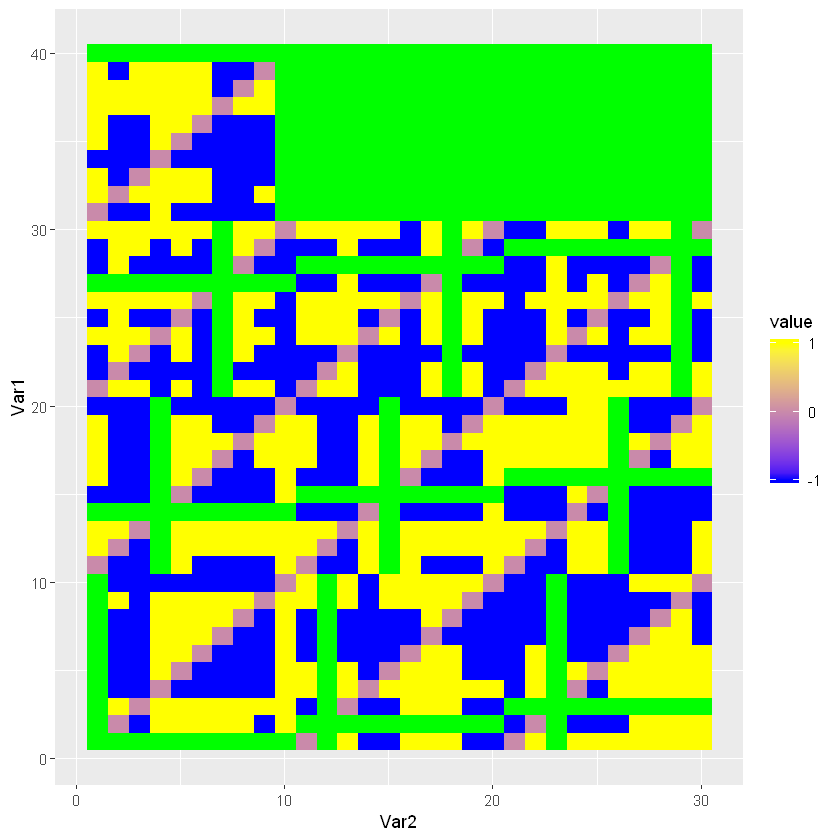

In [257]:
# testing stuff
testmat <- rank.mat.obtain(dr.interpolated)
#rank.mat.plot.set(testmat)
flat <- flatten(testmat)
plot.rank.mat.generic(flat)

In [253]:
# get a list of the flattened matrices for each subject
bs.flat.list <- function(n,var,comparison='CC',n.qualia=n.qualia){
    output <- list()
    k = 1
    for(ID in 1:n){
        
        dr.matrix <- dr(n.samples=n.qualia,Q2,Q1,metric=d.shepard,var=var)
        dr.int <- interpolate.matrix(dr.matrix,method='pearson')
        
        rankmat <- rank.mat.obtain(dr.int)
        flatmat <- flatten(rankmat)
        #print(flatmat[1:10,1:10]) # testing
        output[[k]] <- flatmat
        k = k+1
    }
    return(output)
}

In [169]:
# check whether cell values in a list of flattened matrices are statistically non-zero
flat.zero.test <- function(flat.list, mu = 0, threshold = 0.05, test.mat=FALSE){
    count.non.zero = 0
    count.cells = 0
    output.vec <- vector()
    for (i in 1:length(flat.list[[1]])){ # all the cells
        cell.vals <- vector()
        for (j in 1:length(flat.list)){ # all the matrices
            cell.vals <- c(cell.vals,flat.list[[j]][i])
        }
        if(!all(is.na(cell.vals))){
            count.cells = count.cells + 1
            test <- wilcox.test(cell.vals, mu = 0, alternative = "two.sided",exact=FALSE)
            non.zero <- (test$p.value < threshold)
            if(is.na(non.zero)){ # is this appropriate? Do we count the main diagonal?
                non.zero <- FALSE
            }
            if(non.zero){
                count.non.zero = count.non.zero + 1
            }
            if(test.mat){
                output.vec <- c(output.vec,non.zero)
            }
        } else {
            output.vec <- c(output.vec,NA)
        }
        
    }
    if(test.mat){
        output.mat <- matrix(output.vec,nrow(flat.list[[1]]),ncol(flat.list[[1]]))
        return(output.mat)
    }
    return(count.non.zero/count.cells)
}

In [182]:
# plot a group of flat matrices
flat.group.plot <- function(n,n.qualia,var){
    subject.list <- bs.flat.list(n=n,var=var,comparison='BLAH',n.qualia=n.qualia)
    k = 1 # counter
    plot_list <- list()
    for(subject in 1:length(subject.list)){
        graph <- plot.rank.mat.generic(subject.list[[subject]])
        plot_list[[k]] <- as.grob(graph)
        k = k + 1
    }
    # add a group average plot
    group.average <- Reduce('+',subject.list)/length(subject.list)
    group.average.plot <- plot.rank.mat.generic(group.average)
    plot_list[[k]] <- as.grob(group.average.plot)
    k = k + 1
    
    # add a proportion plot
    non.zero.pr <- flat.zero.test(subject.list)
    plot_list[[k]] <- as.grob(proportion(non.zero.pr))
    
    label <- paste("Qualia - ",n.qualia,"Noise SD - ",var)
    title <- textGrob(label, gp=gpar(fontsize=35))
    x <- round(sqrt(k)) + 1
    g <- arrangeGrob(grobs = plot_list, ncol = x, nrow=x, top=title)
    ggsave(paste(label,'.png'),
           g,height=x*4,width=x*4)
}

In [178]:
# proportion plot
proportion <- function(pr){
    prop <- 100*pr
    non.prop <- 100-prop
    vec <- c(prop,non.prop)
    #labels <- c('Non-zero','Zero')
    labels <- c(paste('Non-zero:',round(prop,1)),paste('Zero: ',round(non.prop,1)))
    df <- data.frame(
        group = labels, value = c(prop,non.prop))
    plot <- ggplot(df, aes(x="", y=value, fill=group)) + geom_bar(width=1, stat= 'identity') +
        xlab("") + ylab("Proportion Non-zero (nonparametric, p < 0.05)")
    return(plot)
}

In [258]:
flat.group.plot(n=10,var=0.25,n.qualia=16)

ERROR: Error in Q2[j, 1:2]: subscript out of bounds


## Simulating Chuyin's Masking Experiments

[Trying to simulate what's on this page](https://docs.google.com/presentation/d/14AsFTZ-GuggPhnmZPPphkqHhr8FPBpghMUcZBZWFVaE/edit#slide=id.gd02deca06b_0_8)

In [63]:
# obtaining the actually empirically-obtained dissimilarity values

vis.1 <- sample.groups(9,1)
dr.vis.1 <- dr.overlap(vis.1,var=0)
#dr.mask.1 <- dr.overlap(vis.1, var=0.5) + 0.25
#dr.vis.2 <- dr.overlap(vis.1,var=0.01)
#plot.mat(dr.vis.1)
#plot.mat(dr.mask.1)
#plot.mat(dr.vis.2)

In [88]:
# obtain across multiple subjects - should average out the random noise
mask.obtain <- function(sample,variation=0.5,offset=0.25,n=50){
    mat.list <- list()
    for(i in 1:n){
        mat.list[[i]] <- dr.overlap(sample,var=variation) + offset
    }
    out <- Reduce('+',mat.list)/length(mat.list)
    return(out)
}

dr.mask.1 <- mask.obtain(vis.1,variation=1,n=1000)
dr.mask.1

,01: G1_Q1,02: G1_Q2,03: G1_Q3,04: G1_Q4,05: G1_Q5,06: G1_Q6,07: G1_Q7,08: G1_Q8,09: G1_Q9
01: G1_Q1,0.6736313,0.6744488,0.7865569,0.8574402,0.9438157,0.9476861,0.8808419,0.7582333,0.6671493
02: G1_Q2,0.7096164,0.6384848,0.6699075,0.8005607,0.8657945,0.9248343,0.9382011,0.9164709,0.7704393
03: G1_Q3,0.8014924,0.7171539,0.6583916,0.6801011,0.7758951,0.8971174,0.9221906,0.9447784,0.8964125
04: G1_Q4,0.8877353,0.7985535,0.6842655,0.6841830,0.7044053,0.7871403,0.8630829,0.9756539,0.8990562
05: G1_Q5,0.9227445,0.8689686,0.7839495,0.7026471,0.6296062,0.6836086,0.7749702,0.8558694,0.9240357
06: G1_Q6,0.9325836,0.9020032,0.9065772,0.7540275,0.6874463,0.6390915,0.7020879,0.8052180,0.8729750
07: G1_Q7,0.8819876,0.9254572,0.9235261,0.8922613,0.7645844,0.7125378,0.6318348,0.7005220,0.7532420
08: G1_Q8,0.8073981,0.8816936,0.8999872,0.9544258,0.8543596,0.7917506,0.7137323,0.6507746,0.6891668
09: G1_Q9,0.7044028,0.7569113,0.8964042,0.9437702,0.9795514,0.8842812,0.7483366,0.7089852,0.6190321


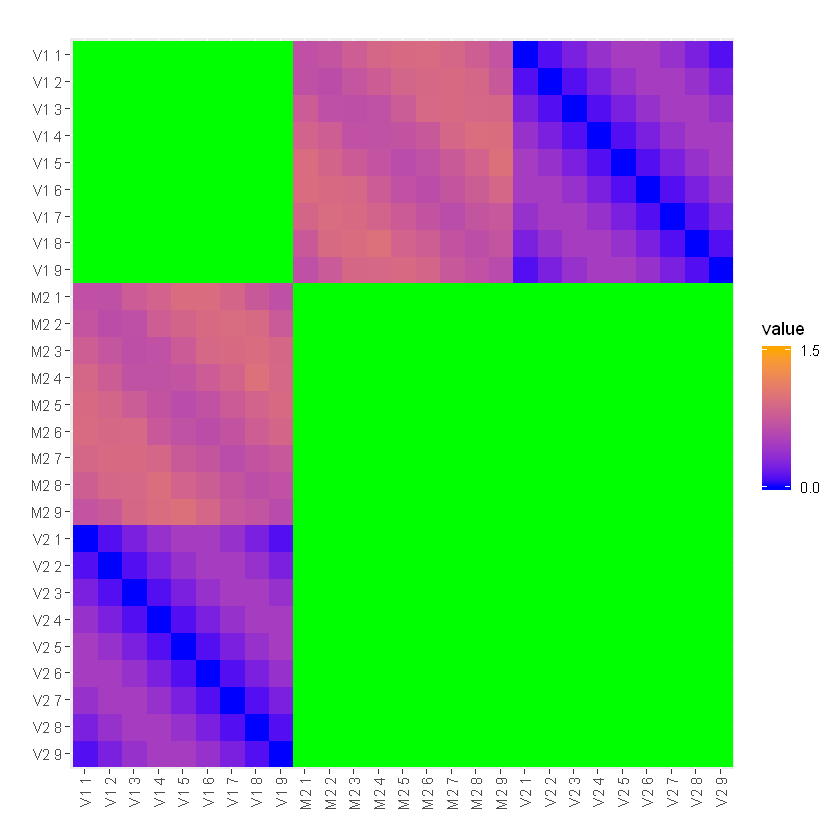

In [89]:
# stitching them together before interpolation

mask.mat.stitch <- function(dr.vis.1, dr.mask.1){
    n.row <- nrow(dr.vis.1)
    # make big matrix
    out.mat <- matrix(,nrow=n.row*3, ncol=n.row*3)
    
    # insert empirical data
    out.mat[(n.row+1):(n.row*2),1:n.row] <- dr.mask.1
    out.mat[(n.row*2+1):(n.row*3),1:n.row] <- dr.vis.1
    
    # transpose
    out.mat[1:n.row,(n.row+1):(n.row*2)] <- t(dr.mask.1)
    out.mat[1:n.row,(n.row*2+1):(n.row*3)] <- t(dr.vis.1)
    
    # label rows
    l <- c(1:n.row)
    l.vis.1 <- paste('V1',as.character(l))
    l.vis.2 <- paste('V2',as.character(l))
    l.mask.2 <- paste('M2',as.character(l))
    names <- c(l.vis.1, l.mask.2,l.vis.2)
    colnames(out.mat) <- names
    rownames(out.mat) <- names
    
    return(out.mat)
}
e.mat <- (mask.mat.stitch(dr.vis.1,dr.mask.1))
plot.mat(e.mat,refactor=FALSE)

In [90]:
int.e.mat <- interpolate.matrix(e.mat)

Plot the matrices

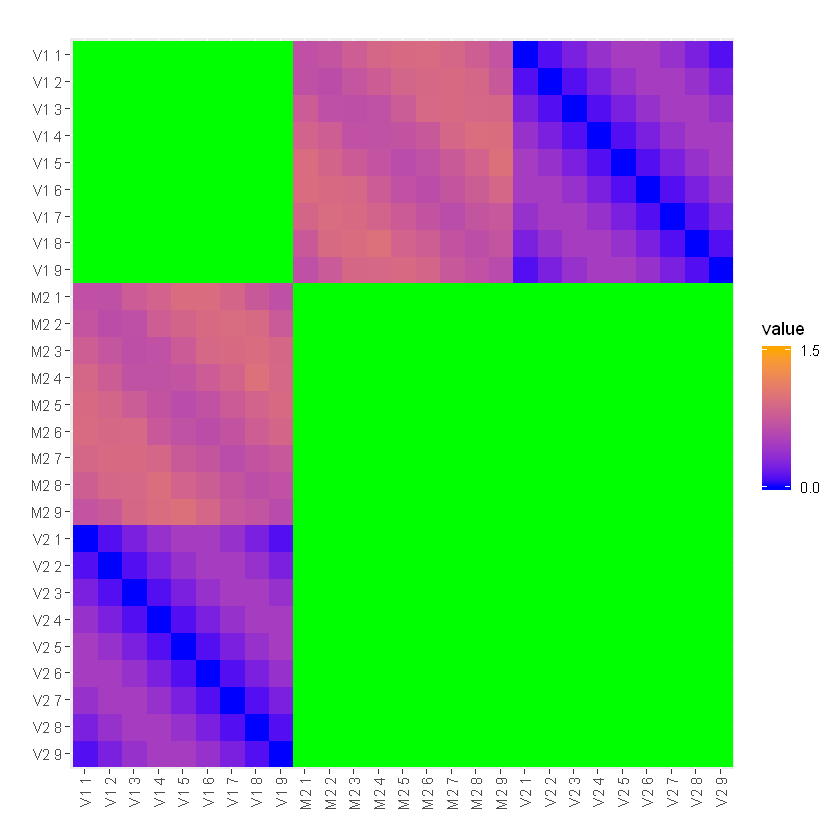

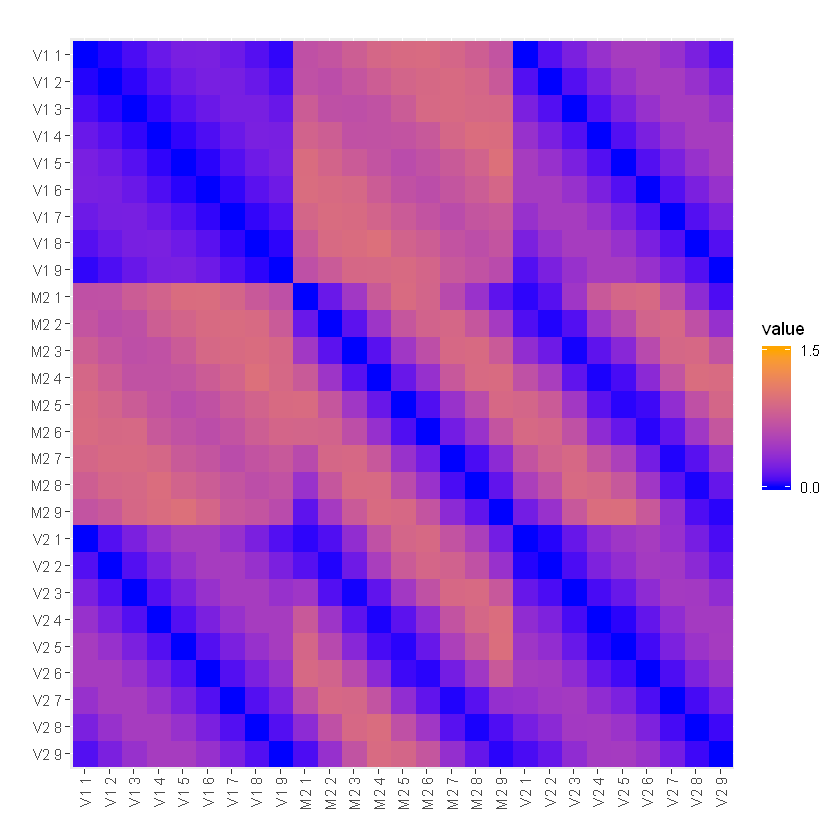

In [91]:
# empirical
plot.mat(e.mat,refactor=FALSE)
# interpolated
plot.mat(int.e.mat,refactor=FALSE)

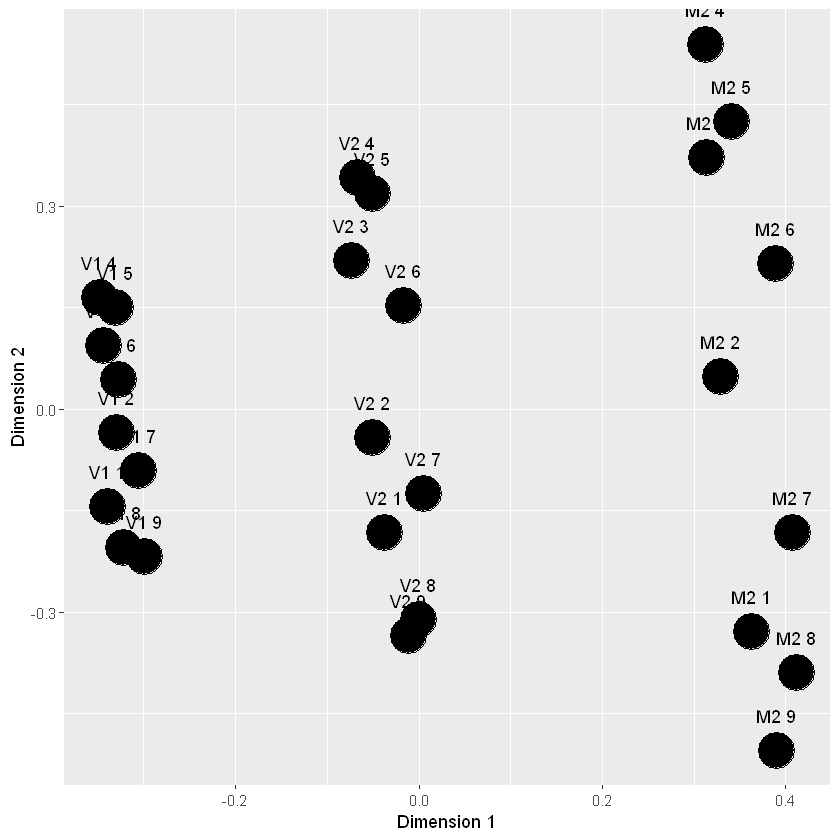

In [92]:
cmds.fuse.plot(int.e.mat)

### Playing around with paper figures

In [169]:
# obtaining the actually empirically-obtained dissimilarity values

vis.1 <- sample.groups(9,1)
dr.vis.1 <- dr.overlap(vis.1,var=0)
#dr.mask.1 <- dr.overlap(vis.1, var=0.5) + 0.25
#dr.vis.2 <- dr.overlap(vis.1,var=0.01)
#plot.mat(dr.vis.1)
#plot.mat(dr.mask.1)
#plot.mat(dr.vis.2)

In [170]:
# obtain across multiple subjects - should average out the random noise
mask.obtain <- function(sample,variation=0.5,offset=0.25,n=50){
    mat.list <- list()
    for(i in 1:n){
        mat.list[[i]] <- dr.overlap(sample,var=variation) + offset
    }
    out <- Reduce('+',mat.list)/length(mat.list)
    return(out)
}

dr.mask.1 <- mask.obtain(vis.1,variation=1.5,offset=0,n=1000)
dr.mask.1

,01: G1_Q1,02: G1_Q2,03: G1_Q3,04: G1_Q4,05: G1_Q5,06: G1_Q6,07: G1_Q7,08: G1_Q8,09: G1_Q9
01: G1_Q1,0.5429306,0.6301975,0.6964879,0.8187397,0.8554652,0.8833615,0.8708105,0.6754645,0.6562277
02: G1_Q2,0.6361159,0.6226918,0.6333319,0.7211631,0.8030638,0.8293160,0.8605899,0.7335022,0.7214341
03: G1_Q3,0.7455551,0.6781172,0.5717102,0.6497916,0.7145334,0.8319650,0.8851752,0.8917841,0.7719981
04: G1_Q4,0.8358789,0.6969064,0.6450023,0.5935522,0.6569957,0.7155898,0.7747458,0.8175288,0.8824854
05: G1_Q5,0.8553297,0.7895139,0.6966272,0.6931661,0.5545042,0.6858918,0.7149474,0.8395951,0.9138662
06: G1_Q6,0.8718384,0.8700156,0.7602628,0.7768127,0.6415390,0.6011215,0.6259119,0.7603986,0.8563725
07: G1_Q7,0.7504860,0.8740974,0.8522954,0.8002984,0.6787923,0.6332135,0.6373266,0.6219058,0.6853560
08: G1_Q8,0.6843657,0.8743848,0.8673832,0.8377139,0.8156765,0.7463722,0.6421018,0.5942062,0.6458882
09: G1_Q9,0.6673325,0.7584778,0.7933725,0.8724543,0.8625623,0.7995182,0.7245827,0.6451403,0.5978147


In [171]:
# just using null values
dr.mask.2 <- matrix( runif(81),nrow=9)
dr.mask.2

#dr.mask.3 <- matrix(c(0.5,0.51,0.49,0.51,0.5,0.49,0.49,0.5,0.5))
dr.mask.3 <- rnorm()

0.9242777,0.59365859,0.49460059,0.25303239,0.03633052,0.53452201,0.09233454,0.9836634,0.54054048
0.5307554,0.77019178,0.80085998,0.92182506,0.64723213,0.20689915,0.27580890,0.4124658,0.01290353
0.3635552,0.58011371,0.50551622,0.35082194,0.57712009,0.38860813,0.51587841,0.7276825,0.42936874
0.9915238,0.83477207,0.85624754,0.59879637,0.17986287,0.63963706,0.97974171,0.1834205,0.97050150
0.7367385,0.34811595,0.22852743,0.37571217,0.98994189,0.94315971,0.35484398,0.4101571,0.90234773
0.6797169,0.05449952,0.11901762,0.06299914,0.60050604,0.04678041,0.92325010,0.6829572,0.48438386
0.1412625,0.32909463,0.54026377,0.90195006,0.38770686,0.66248273,0.42210269,0.5572556,0.02125495
0.2307357,0.13364185,0.85755657,0.74423114,0.58258153,0.44881113,0.18667611,0.1338127,0.92150734
0.1726343,0.22296085,0.08582544,0.80365002,0.71247104,0.55408180,0.19217715,0.5720221,0.10597935


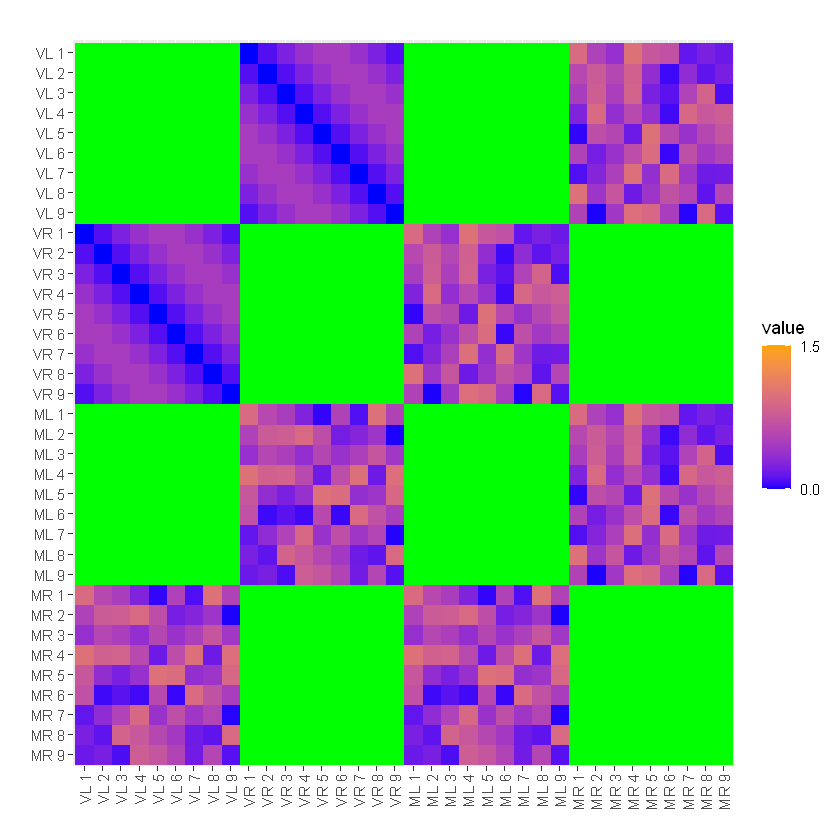

In [204]:
# stitching them together before interpolation

mask.mat.stitch.2 <- function(dr.vis.1, dr.mask.1,rand=FALSE){
    n.row <- nrow(dr.vis.1)
    # make big matrix
    out.mat <- matrix(,nrow=n.row*4, ncol=n.row*4)
    
    # insert empirical data
    if(rand){
        out.mat[(n.row+1):(n.row*2),1:n.row] <- dr.vis.1
        out.mat[(n.row*3+1):(n.row*4),1:n.row] <- rnorm(n.row*n.row,mean=0.5,sd=0.05)
        out.mat[(n.row*2+1):(n.row*3),(n.row+1):(n.row*2)] <- rnorm(n.row*n.row,mean=0.5,sd=0.05)
        out.mat[(n.row*3+1):(n.row*4),(n.row*2+1):(n.row*3)] <- rnorm(n.row*n.row,mean=0.5,sd=0.05)
    } else {
        out.mat[(n.row+1):(n.row*2),1:n.row] <- dr.vis.1
        out.mat[(n.row*3+1):(n.row*4),1:n.row] <- dr.mask.1
        out.mat[(n.row*2+1):(n.row*3),(n.row+1):(n.row*2)] <- dr.mask.1
        out.mat[(n.row*3+1):(n.row*4),(n.row*2+1):(n.row*3)] <- dr.mask.1
    }
    
    
    # transpose
    out.mat[1:n.row,(n.row+1):(n.row*2)] <- t(out.mat[(n.row+1):(n.row*2),1:n.row])
    out.mat[1:n.row,(n.row*3+1):(n.row*4)] <- t(out.mat[(n.row*3+1):(n.row*4),1:n.row])
    out.mat[(n.row+1):(n.row*2),(n.row*2+1):(n.row*3)] <- t(out.mat[(n.row*2+1):(n.row*3),(n.row+1):(n.row*2)])
    out.mat[(n.row*2+1):(n.row*3),(n.row*3+1):(n.row*4)] <- t(out.mat[(n.row*3+1):(n.row*4),(n.row*2+1):(n.row*3)])
    
    # label rows
    l <- c(1:n.row)
    l.vis.L <- paste('VL',as.character(l))
    l.vis.R <- paste('VR',as.character(l))
    l.mask.L <- paste('ML',as.character(l))
    l.mask.R <- paste('MR',as.character(l))
    names <- c(l.vis.L, l.vis.R, l.mask.L,l.mask.R)
    colnames(out.mat) <- names
    rownames(out.mat) <- names
    
    #print(out.mat)
    return(out.mat)
}
e.mat.2 <- (mask.mat.stitch.2(dr.vis.1,dr.mask.2,rand=FALSE))
plot.mat(e.mat.2,refactor=FALSE)

In [205]:
int.e.mat.2 <- interpolate.matrix(e.mat.2)

Plot the matrices

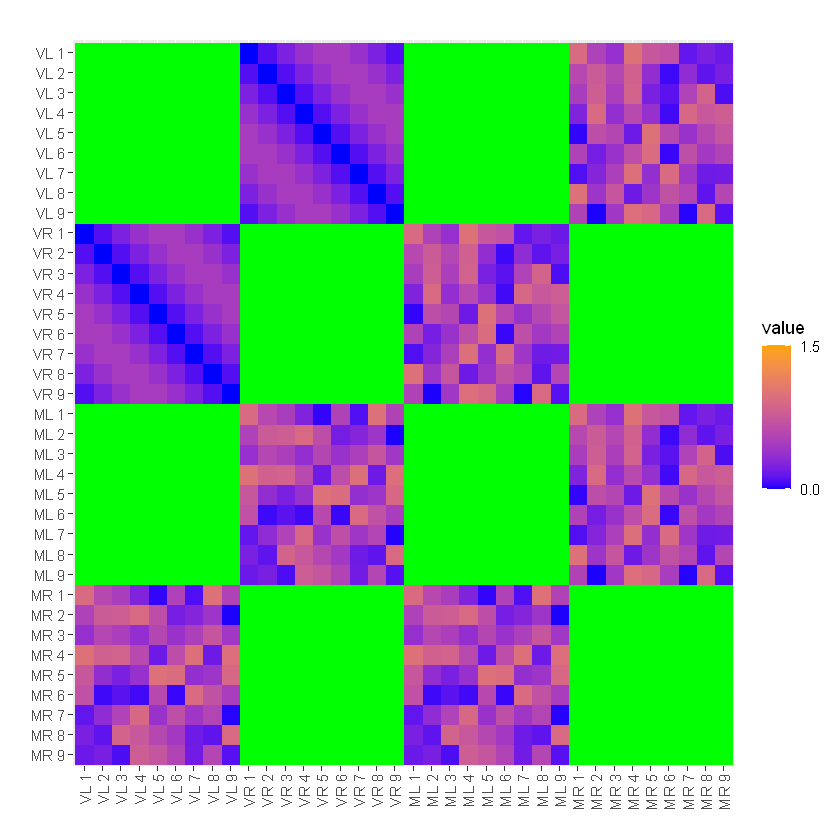

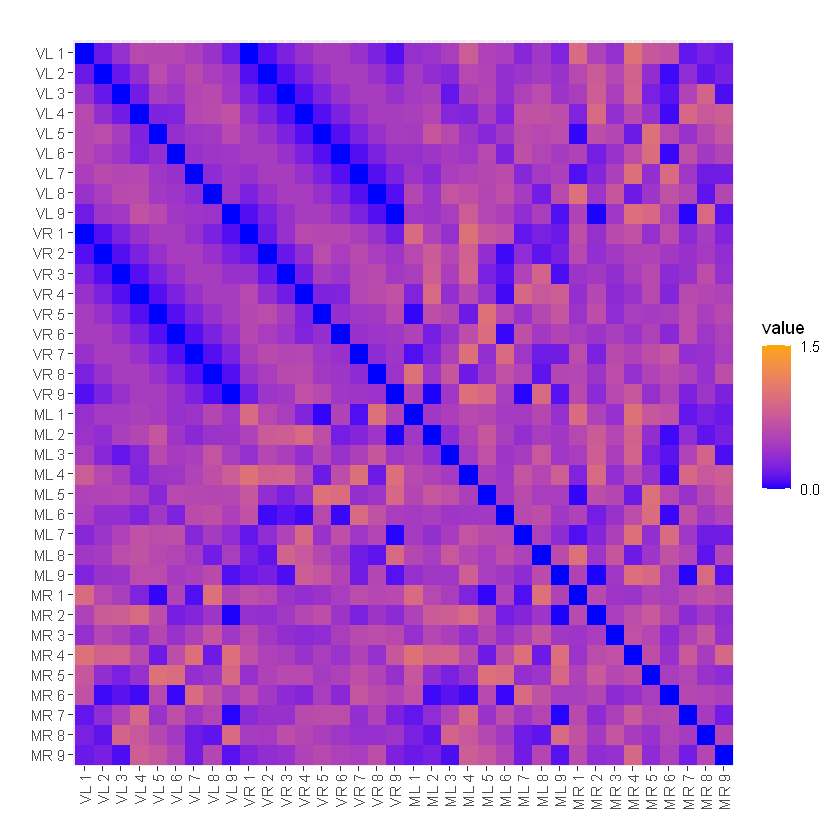

In [206]:
# empirical
plot.mat(e.mat.2,refactor=FALSE)
# interpolated
plot.mat(int.e.mat.2,refactor=FALSE)

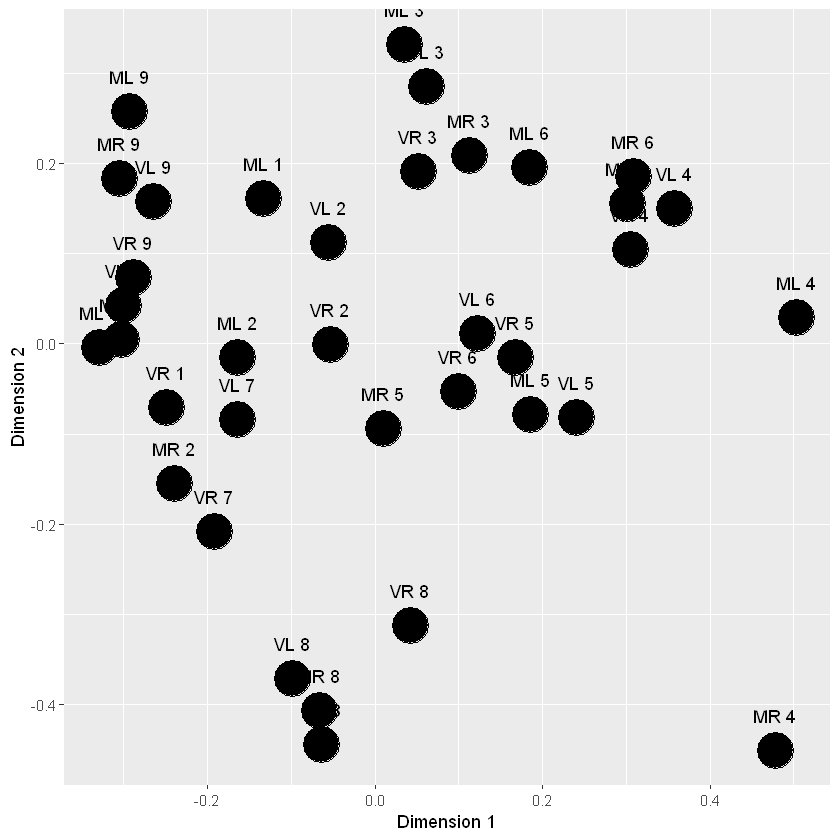

In [207]:
cmds.fuse.plot(int.e.mat.2)